In [1]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
import matplotlib.pyplot
from PIL import Image
%env SM_FRAMEWORK=tf.keras 
%matplotlib inline

env: SM_FRAMEWORK=tf.keras


# Baixando bases e modelos

In [2]:
#Pegando os dados que serão utilizados do Kaggle

os.environ['KAGGLE_USERNAME'] = "lucascunhadecarvalho"
os.environ['KAGGLE_KEY'] = "66aee9f83fd989281d28d8832f428c68"

def classData ():
  !kaggle datasets download -d lucascunhadecarvalho/odir-5k #Dataset utilizado na classificação
  !unzip -q odir-5k

def classDataRimOne ():
  !kaggle datasets download -d lucascunhadecarvalho/rimone-glaucoma #Dataset utilizado na classificação
  !unzip -q rimone-glaucoma

def baixaModelos ():
  !kaggle datasets download -d lucascunhadecarvalho/modelostreinadossegmentacao #Dataset utilizado na segmentação de veias
  !unzip -q modelostreinadossegmentacao

classData () #Caso queira realizara a classificação de estruturas de fundo de olho
classDataRimOne ()
baixaModelos() #Baixando os modelos treinados de segmentação - arquivos segmentation 

100% 1.25G/1.26G [00:10<00:00, 95.1MB/s]
100% 1.26G/1.26G [00:10<00:00, 126MB/s] 
 64% 24.0M/37.6M [00:00<00:00, 57.6MB/s]
100% 37.6M/37.6M [00:00<00:00, 94.9MB/s]
100% 1.25G/1.25G [00:31<00:00, 36.2MB/s]
100% 1.25G/1.25G [00:31<00:00, 42.7MB/s]


# DataGen segmentação

In [3]:
#读取数据
class DataGen(keras.utils.Sequence):  
    def __init__(self, ids, path, batch_size=8, image_size=256):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size#一次训练样本数
        self.image_size = image_size#图片大小
        self.on_epoch_end()
        
    def __load__(self, id_name):
        #文件路径
        image_path = os.path.join(self.path, "", id_name) + ".jpg" #Carregando imagens
        
        #分别读原图、正确分割的图
        #Lendo e convertendo a imagem para RGB (Segmentação do disco)
        image = cv2.imread(image_path, 1) #Lendo a imagem
        b,g,r = cv2.split(image)      
        image = cv2.merge([r,g,b]) 
        # 
        image = cv2.resize(image, (self.image_size, self.image_size))#调整大小
        
        
        #图像进行归一化，范围为[0, 1]
        image = image/255.0
        
        return image
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        
        for id_name in files_batch:
            _img = self.__load__(id_name)
            image.append(_img)
            
        image = np.array(image)
        
        return image   #返回数组
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

# Organizando arquivos

In [4]:
image_size = 256 #Tamanho das imagens, valor alterável, assegure-se de usar um valor múltiplo de 32
path = "./Imagens"#Caminho da validação
train_path = "./Training Images" #Caminho das imagens treino
test_path = "./Testing Images" #Caminho das imagens teste
batch_size = 8 #Variável de acordo com a base de dados


train_ids = []
for files in os.walk(train_path):#Percorrendo diretórios
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]#Obtendo os nomes dos arquivos
train_ids = [i.split('.', 1)[0] for i in train_ids]#Separando os nomes (IDS) de seus sufixos (.png)


test_ids = []
for files in os.walk(test_path):#Percorrendo diretórios
  for name in files:
    test_ids.append(name)

test_ids = test_ids[2]#Obtendo os nomes dos arquivos
test_ids = [i.split('.', 1)[0] for i in test_ids]#Separando os nomes (IDS) de seus sufixos (.png)

In [5]:
!pip install segmentation_models #Biblioteca com modelos de redes neurais para segmentação de imagens
import segmentation_models as sm
from keras.losses import binary_crossentropy
from keras import backend as K
from tensorflow.keras import layers

     |████████████████████████████████| 50 kB 4.7 MB/s 
Segmentation Models: using `tf.keras` framework.


# Carregando modelos de segmentação treinados

In [6]:
from keras.models import load_model

model_veias = load_model('Modelo_VS.h5', custom_objects={'binary_focal_loss_plus_dice_loss': sm.losses.binary_focal_dice_loss,
                                                      'iou_score': sm.metrics.iou_score,
                                                      'f1-score': sm.metrics.f1_score})

model_disco = load_model('Modelo_DO.h5', custom_objects={'binary_crossentropy_plus_dice_loss': sm.losses.bce_dice_loss,
                                                      'iou_score': sm.metrics.iou_score,
                                                      'f1-score': sm.metrics.f1_score})

# model_veias.summary() #Tire os comentários destas linhas caso deseje ver cada layer dos modelos
# model_disco.summary()

# Criando pastas para guardar imagens segmentadas

In [7]:
os.mkdir('predictions')
os.mkdir('predictions_veias')

# Segmentação do Disco Óptico

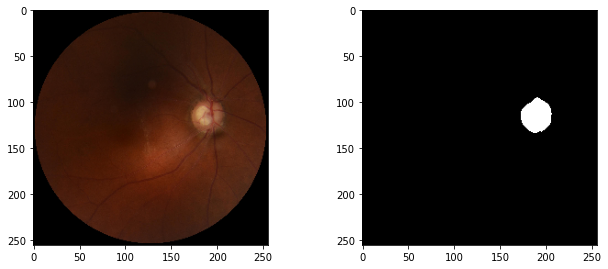

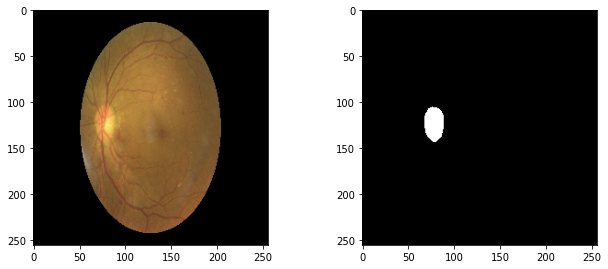

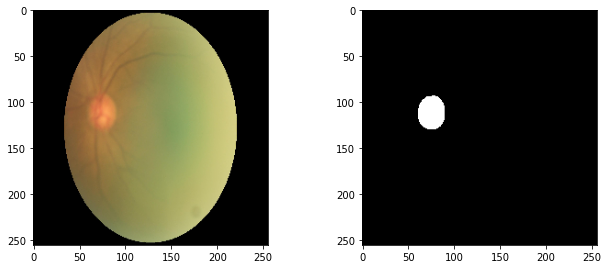

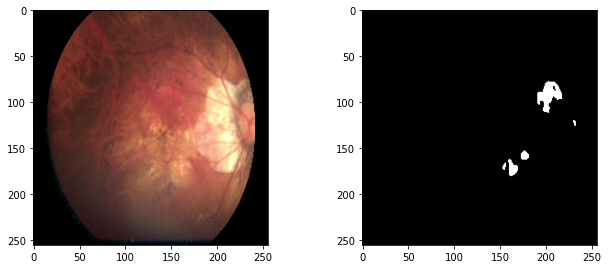

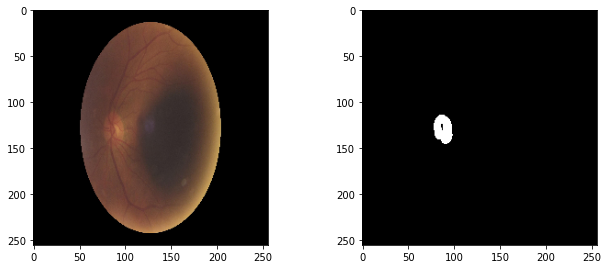

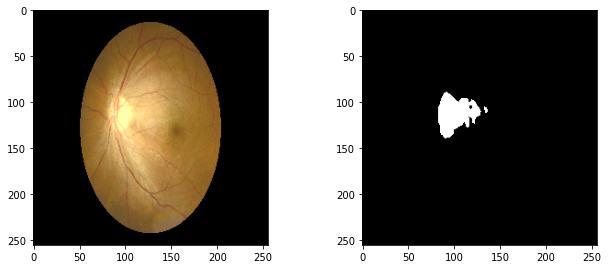

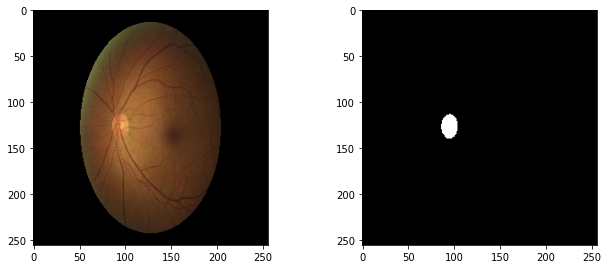

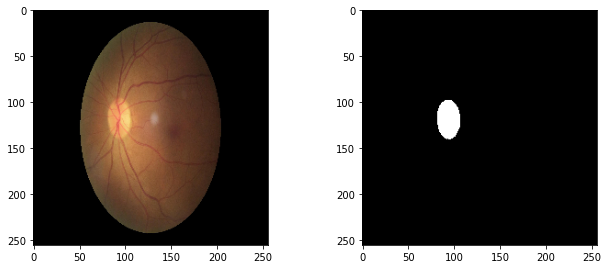

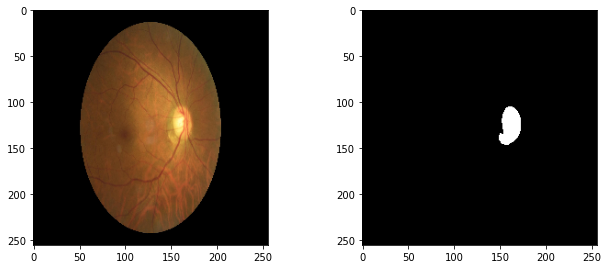

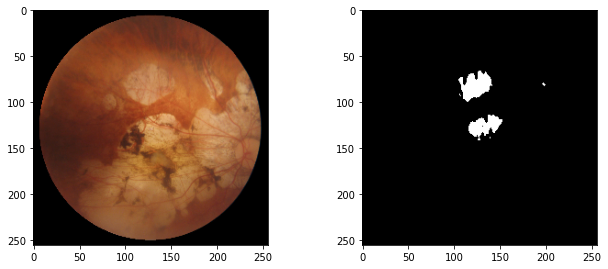

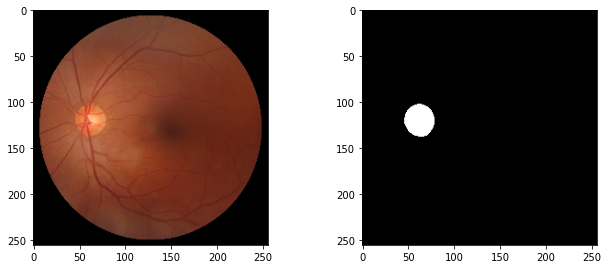

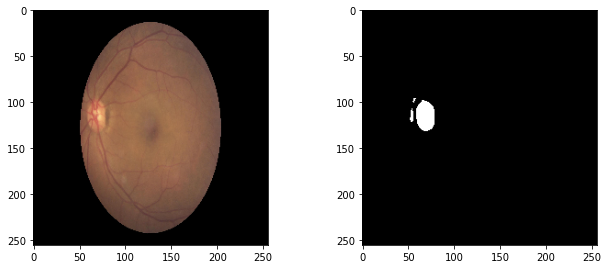

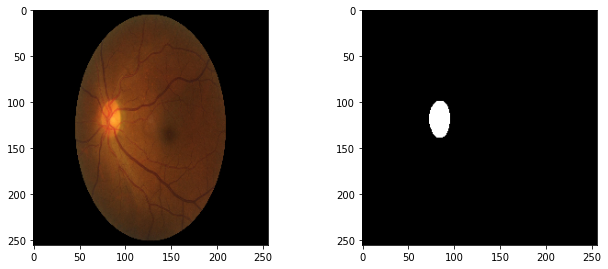

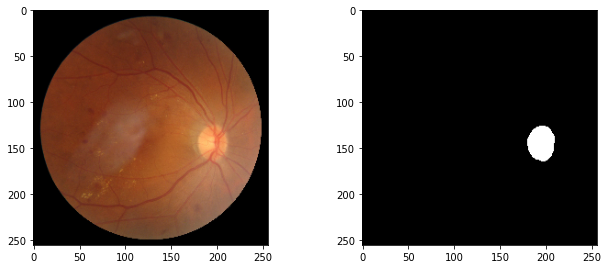

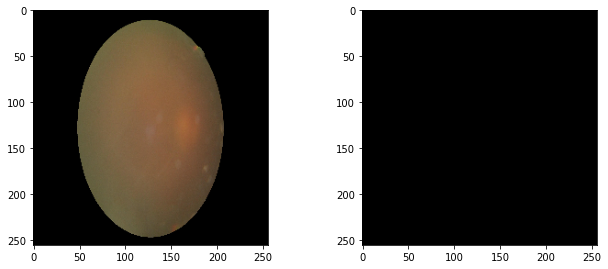

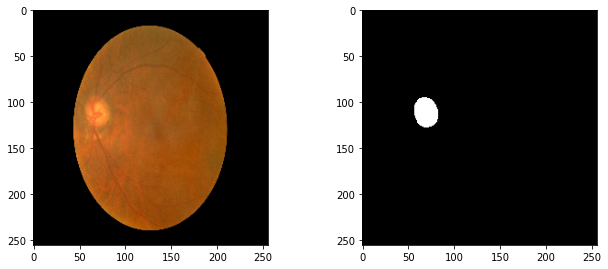

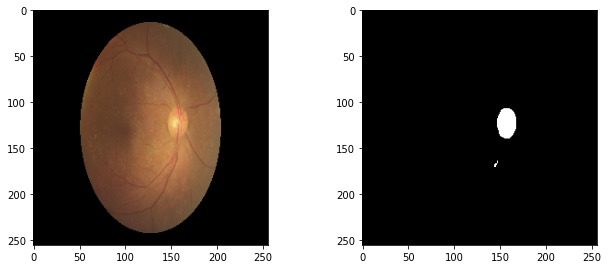

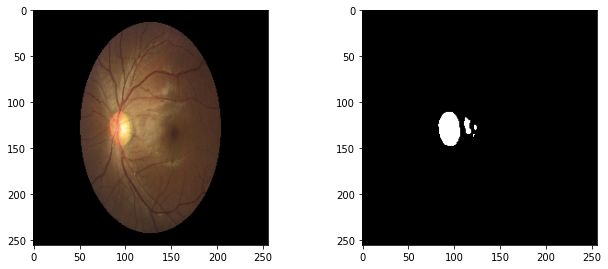

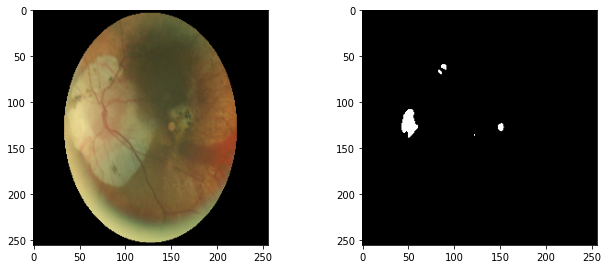

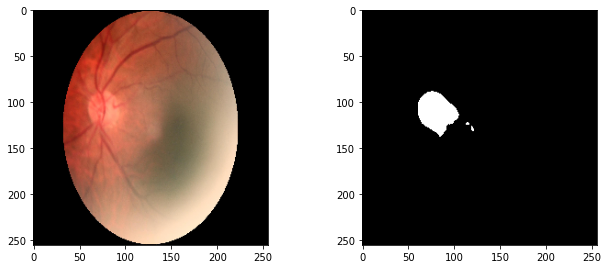

In [8]:
def resultadosModeloSegmentacaoOdirDO (model):
  test_gen = DataGen(train_ids, train_path, 1, 256)
  show = 0

  for i in range(0, 20): #Apenas 20 imagens como demonstração
    x = test_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.5
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    if show <= 20:
      ax = fig.add_subplot(1, 3, 1)
      ax.imshow(x[0])

      ax = fig.add_subplot(1, 3, 2)
      ax.imshow(np.reshape(result[0]*255, (256, 256)), cmap="gray")

    pred = np.dstack([result[0], result[0], result[0]])
    pred = (pred * 255).astype(np.uint8)
    
    nome_imagem = 'predictions/' + train_ids[i] + '_pred' + '.png'
    img = Image.fromarray(pred, 'RGB')
    img.save(nome_imagem)
    cv2.imwrite(nome_imagem, pred)
    im = Image.open(nome_imagem)
    im.save(nome_imagem, "png")
    show += 1

resultadosModeloSegmentacaoOdirDO (model_disco)

# Pré-processamento para segmentação de veias
Método CLAHE

In [9]:
import cv2
from skimage import io
from matplotlib import pyplot as plt

#Estabelecendo métodos de pré-processamentode imagens que podem ser necessários

def metodoClahe (img): #Método de pré-processamento que auxilia no realce de estruturas como veias sanguineas

  img = cv2.imread(img, 1) #Lendo a imagem
  #Convertendo a imagem para RGB
  b,g,r = cv2.split(img)      
  img = cv2.merge([r,g,b])  


  lab_img= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

  #Dividindo a LAB image em três canais: L, A e B, respectivamente  
  l, a, b = cv2.split(lab_img)

  ###########Equalização de histograma#############
  #Aplicando uma equalização de histograma ao canal L
  equ = cv2.equalizeHist(l)

  #Juntando o canal L com histograma equalizado com os canais A e B
  updated_lab_img1 = cv2.merge((equ,a,b))

  #Convertendo a LAB image de volta para as cores originais (RGB)
  hist_eq_img = cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)

  ###########CLAHE#########################
  #Aplicando CLAHE ao canal L
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_img = clahe.apply(l)

  #Juntando canal L com CLAHE aplicado com os canais A e B
  updated_lab_img2 = cv2.merge((clahe_img,a,b))

  #Convertendo a LAB image de volta para as cores originais (RGB)
  CLAHE_img = cv2.cvtColor(updated_lab_img2, cv2.COLOR_LAB2BGR)
 
  return CLAHE_img

In [10]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
import matplotlib.pyplot
from PIL import Image

# Ajustando o DataGen para a segmentação de veias
Este DataGen implementa o método CLAHE de pré-processamento

In [11]:
import tensorflow as tf
from tensorflow import keras

#读取数据
class DataGen(keras.utils.Sequence):  
    def __init__(self, ids, path, batch_size=8, image_size=256):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size#一次训练样本数
        self.image_size = image_size#图片大小
        self.on_epoch_end()
        
    def __load__(self, id_name):
        #文件路径
        image_path = os.path.join(self.path, "", id_name) + ".jpg" #Carregando imagens
        
        #分别读原图、正确分割的图
        #Lendo e convertendo a imagem para RGB (Segmentação do disco)
        #image = cv2.imread(image_path, 1) #Lendo a imagem
        image = metodoClahe(image_path)
        #b,g,r = cv2.split(image)      
        #image = cv2.merge([r,g,b]) 
        # 
        image = cv2.resize(image, (self.image_size, self.image_size))#调整大小
      
        
        #图像进行归一化，范围为[0, 1]
        image = image/255.0
        
        return image
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        
        for id_name in files_batch:
            _img = self.__load__(id_name)
            image.append(_img)
            
        image = np.array(image)
        
        return image   #返回数组
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

# Segmentação de veias sanguíneas

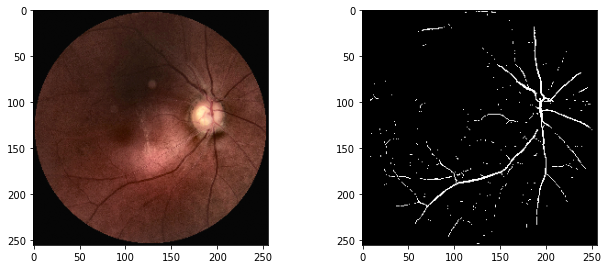

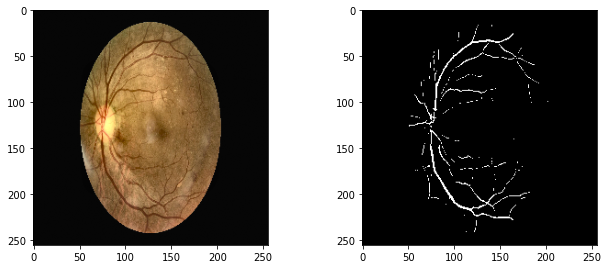

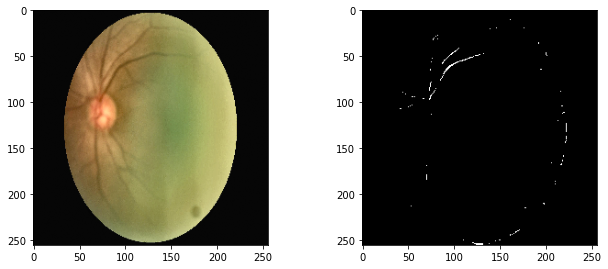

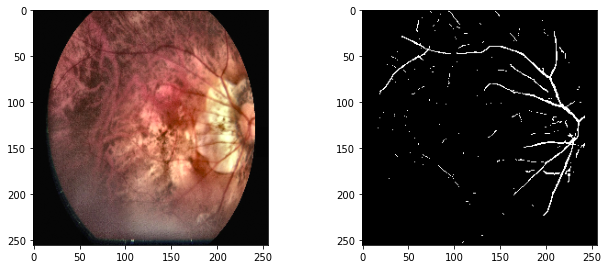

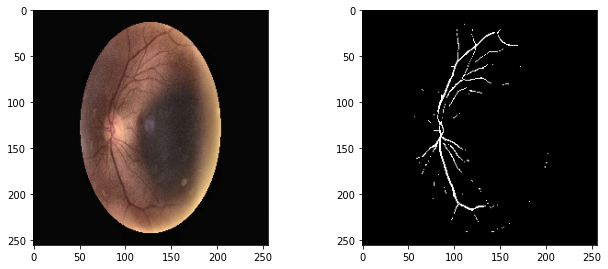

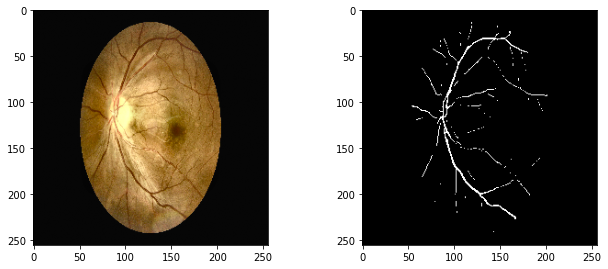

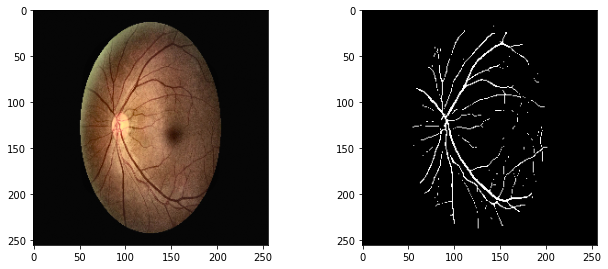

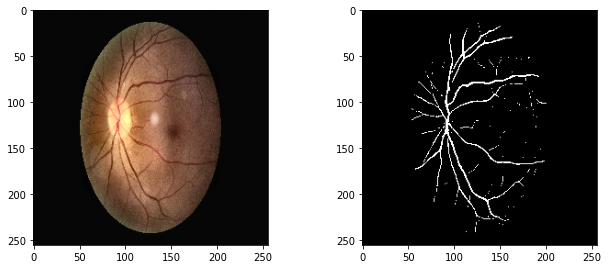

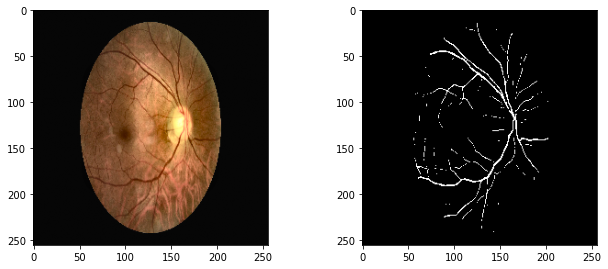

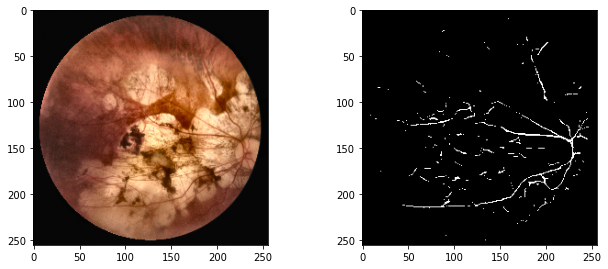

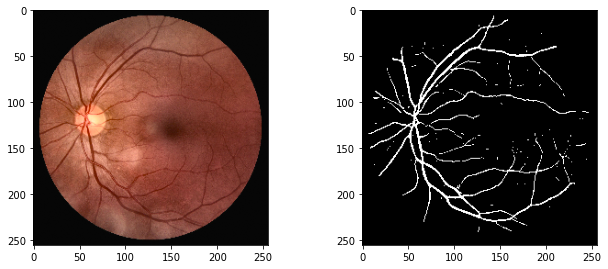

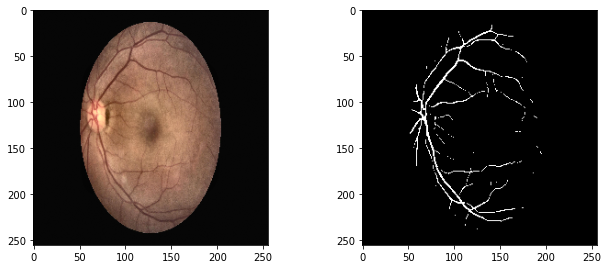

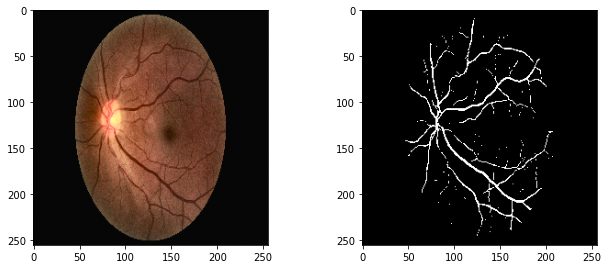

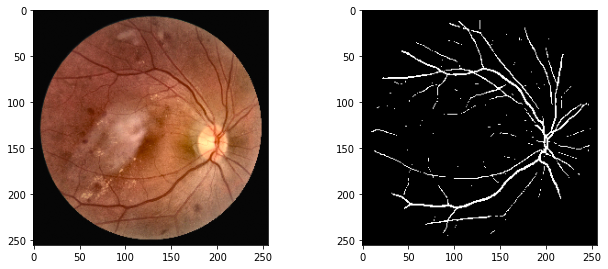

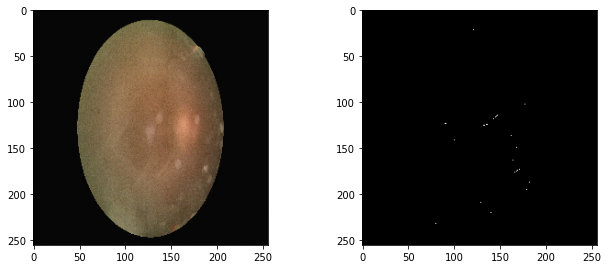

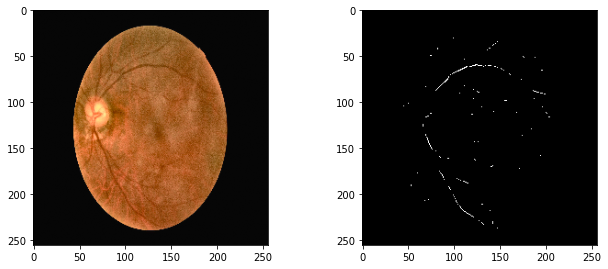

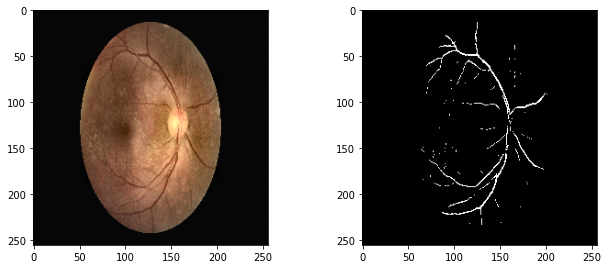

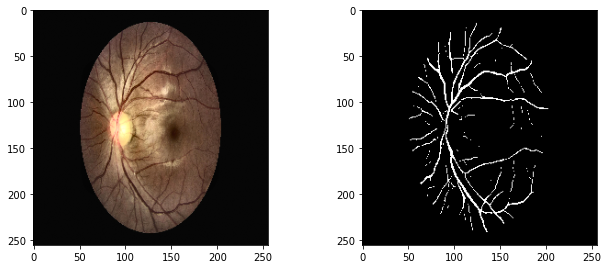

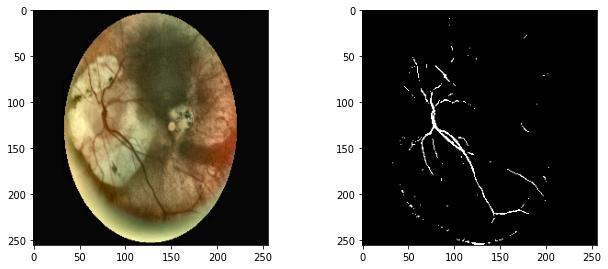

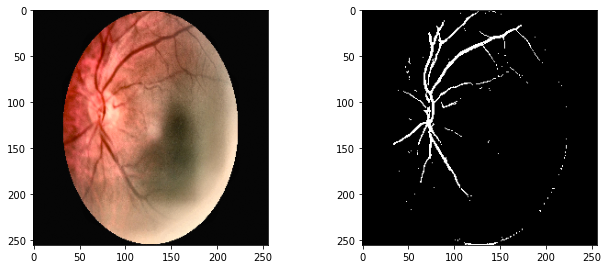

In [12]:
def resultadosModeloSegmentacaoOdirVeias (model):
  test_gen = DataGen(train_ids, train_path, 1, 256)
  show = 0

  for i in range(0, 20):
    
    x = test_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.5
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    if show <= 20:
      ax = fig.add_subplot(1, 3, 1)
      ax.imshow(x[0])

      ax = fig.add_subplot(1, 3, 2)
      ax.imshow(np.reshape(result[0]*255, (256, 256)), cmap="gray")

    pred = np.dstack([result[0], result[0], result[0]])
    pred = (pred * 255).astype(np.uint8)
      
    nome_imagem = 'predictions_veias/' + train_ids[i] + '_pred' + '.png'
    
    img = Image.fromarray(pred, 'RGB')
    img.save(nome_imagem)
    cv2.imwrite(nome_imagem, pred)
    im = Image.open(nome_imagem)
    im.save(nome_imagem, "png")
    show += 1
resultadosModeloSegmentacaoOdirVeias (model_veias)

# Organizando arquivos em segmentação e imagens de fundo de olho

In [13]:
!pip install split-folders
os.mkdir('DO_class')
os.mkdir('VS_class')
os.mkdir('Odir5k')

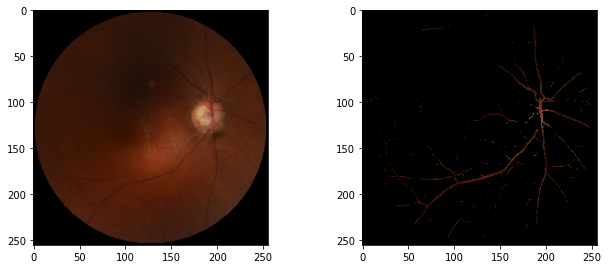

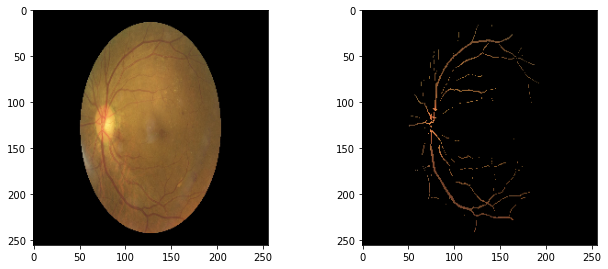

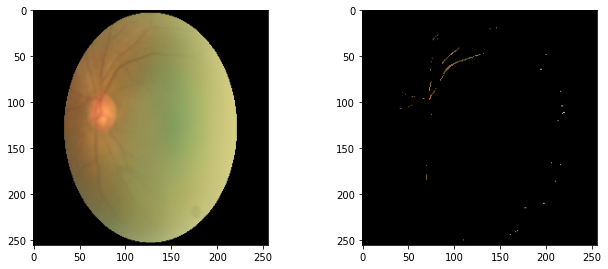

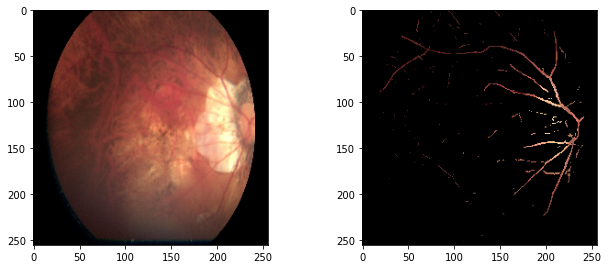

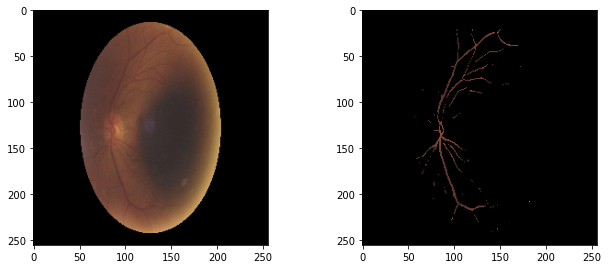

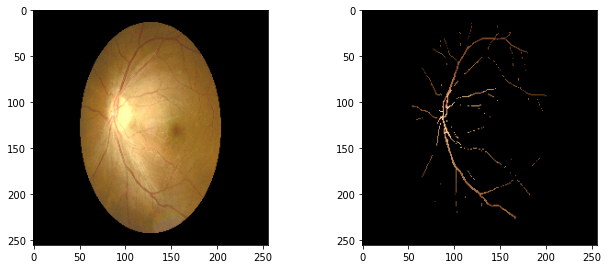

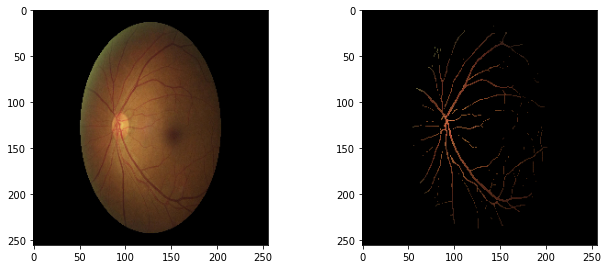

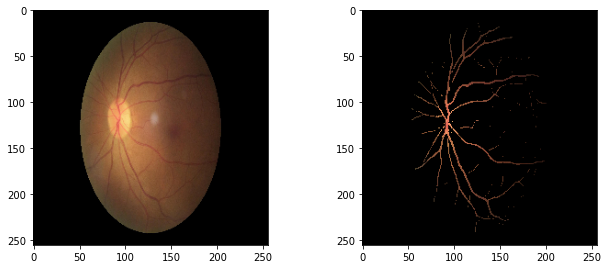

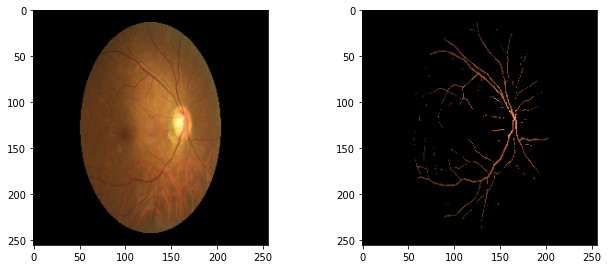

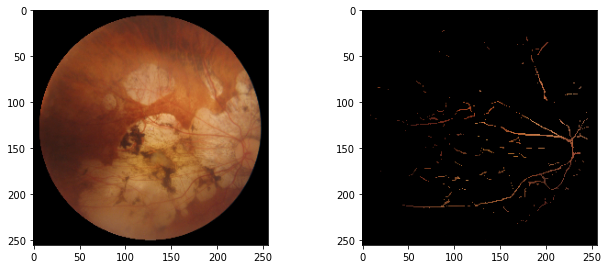

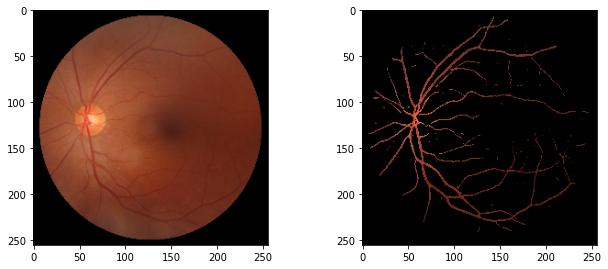

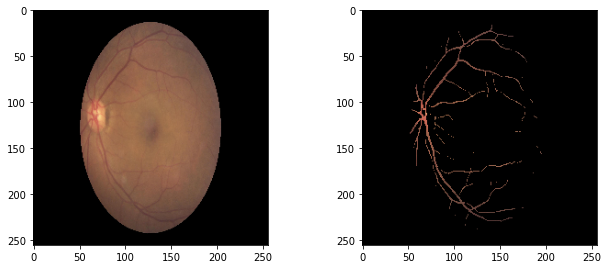

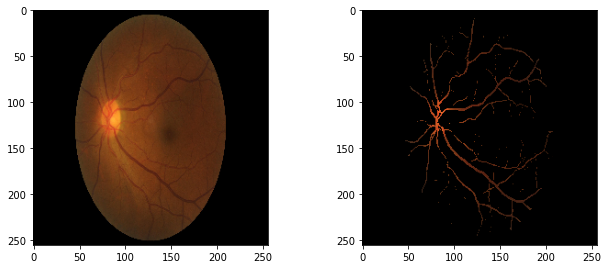

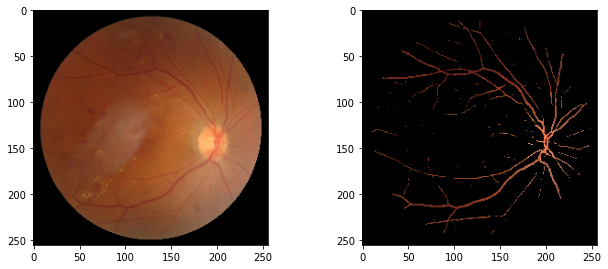

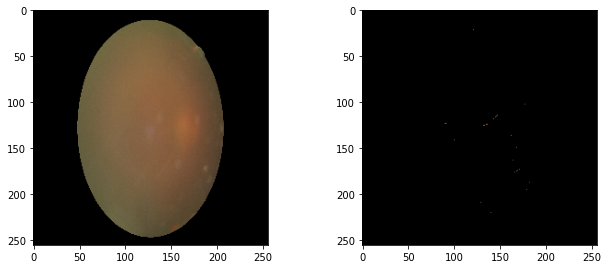

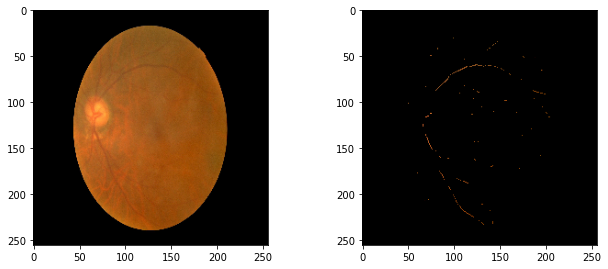

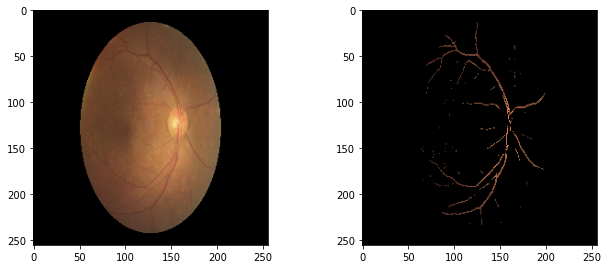

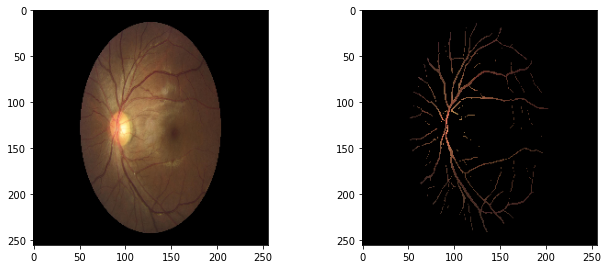

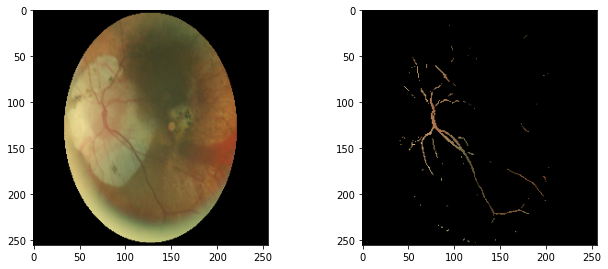

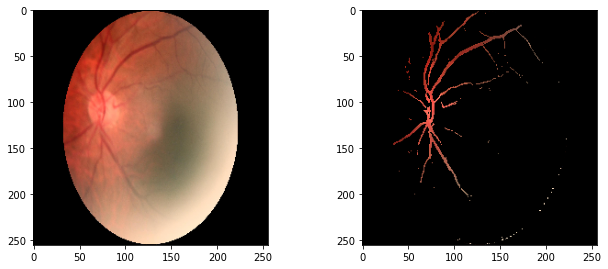

In [14]:
from matplotlib.pyplot import imread
import splitfolders
import shutil

def moveSegmentacoes():
  for i in range(0, 20):

    image_path = "Training Images/" + train_ids[i] + ".jpg"
    image = cv2.imread(image_path, 1)
    image = cv2.resize(image, (256, 256))
    b,g,r = cv2.split(image)      
    image = cv2.merge([r,g,b])

    mask_path_VS = "predictions_veias/" + train_ids[i] + "_pred.png"
    mask_path_DO = "predictions/" + train_ids[i] + "_pred.png"

    mask_VS = cv2.imread(mask_path_VS, 0)
    mask_DO = cv2.imread(mask_path_DO, 0)

    masked_image_VS = cv2.bitwise_and(image, image, mask=mask_VS)
    masked_image_DO = cv2.bitwise_and(image, image, mask=mask_DO)

    save_path_VS = "VS_class/" + train_ids[i] + ".png"
    save_path_DO = "DO_class/" + train_ids[i] + ".png"
  
    cv2.imwrite(save_path_VS, masked_image_VS)
    cv2.imwrite(save_path_DO, masked_image_DO)

    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(image)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(masked_image_VS)

moveSegmentacoes()

# Funções para separar arquivos em classes

Estas funções serão responsáveis por dividir as imagens em 3 classes: "Normal", "Diabetes" e "Glaucoma"

In [ ]:
class imgClass():
  def __init__(self, name, normal, diabetes, glaucoma, catarata, degeneracao, 
              hipertensao, miopia, outras_doencas):
    self.name = name
    self.normal = normal
    self.diabetes = diabetes
    self.glaucoma = glaucoma
    self.catarata = catarata
    self.degeneracao = degeneracao
    self.hipertensao = hipertensao
    self.miopia = miopia
    self.outras_doencas = outras_doencas


def binarySearch (arr, l, r, x):
  
    # Check base case
    if r >= l:
  
        mid = l + (r - l) // 2
        # If element is present at the middle itself
        if arr[mid].name == x:
            return arr[mid].normal,arr[mid].diabetes, arr[mid].glaucoma, arr[mid].catarata, arr[mid].degeneracao, arr[mid].hipertensao, arr[mid].miopia, arr[mid].outras_doencas, arr[mid].name
          
        # If element is smaller than mid, then it 
        # can only be present in left subarray
        elif arr[mid].name > x:
            return binarySearch(arr, l, mid-1, x)
  
        # Else the element can only be present 
        # in right subarray
        else:
            return binarySearch(arr, mid + 1, r, x)
  
    else:
        # Element is not present in the array
        return -1, -1
  
def criaPastas (path, classes):
  for i in range(0, len(classes)):
    os.mkdir(path + "/" + classes[i])

def organizaImagensFinal (path, imagens, imgClasses, valorMax):
  img_ids = [i.split('.', 1)[0] for i in imagens]
  toRemove = []
  normalC = 0
  diabetesC = 0
  glaucomaC = 0
  catarataC = 0
  degeneracaoC = 0
  hipertensaoC = 0
  miopiaC = 0
  outras_doencasC = 0

  for i in range(0, len(img_ids)):
    normal, diabetes,glaucoma, catarata, degeneracao, hipertensao, miopia, outras_doencas, img = binarySearch(imgClasses, 0, len(imgClasses) - 1, img_ids[i])
    
    original = path + "/" + str(imagens[i])
    if (normal == 1) and (normalC < valorMax):
      shutil.copyfile(original, path + "/" + "Normal/" + str(imagens[i]))
      normalC += 1
    if (diabetes == 1) and (diabetesC < valorMax):
      shutil.copyfile(original, path + "/" + "Diabetes/" + str(imagens[i]))
      diabetesC += 1
    if (glaucoma == 1) and (glaucomaC < valorMax):
      shutil.copyfile(original, path + "/" + "Glaucoma/" + str(imagens[i]))
      glaucomaC += 1
    
    toRemove.append(original)

  print(" normal = ", normalC, "\ndiabetes = ", diabetesC, "\nglaucoma = ", glaucomaC, "\ncatarata", catarataC,
        "\ndegeneracao = ", degeneracaoC, "\nhipertensao = ", hipertensaoC, "\nmiopia = ", miopiaC, 
        "\noutras_doencas = ", outras_doencasC)
  for i in range (0, len(toRemove)):
    os.remove(toRemove[i])

# Dividindo arquivos entre treino, validação e teste
70% 20% 10%

In [ ]:
import shutil

def organizaImagensSegmentadas():
  files_DO = os.listdir("DO_class")
  files_VS = os.listdir("VS_class")

  train_ratio = len(files_DO)*0.7
  val_ratio = len(files_DO)*0.2
  test_ratio = len(files_DO)*0.1

  train_ratio = int(train_ratio)
  val_ratio = int(val_ratio)
  test_ratio = int(test_ratio)

  os.mkdir("DO_class/train")
  os.mkdir("DO_class/val")
  os.mkdir("DO_class/test")

  os.mkdir("VS_class/train")
  os.mkdir("VS_class/val")
  os.mkdir("VS_class/test")

  for i in range (0, train_ratio):
    shutil.move("DO_class/" + files_DO[i], "DO_class/train")
    shutil.move("VS_class/" + files_VS[i], "VS_class/train")

  files_DO = files_DO[train_ratio:]
  files_VS = files_VS[train_ratio:]

  for i in range (0, val_ratio):
    shutil.move("DO_class/" + files_DO[i], "DO_class/val")
    shutil.move("VS_class/" + files_VS[i], "VS_class/val")

  files_DO = files_DO[val_ratio:]
  files_VS = files_VS[val_ratio:]

  for i in range (0, test_ratio):
    shutil.move("DO_class/" + files_DO[i], "DO_class/test")
    shutil.move("VS_class/" + files_VS[i], "VS_class/test")

  files_DO = files_DO[test_ratio:]
  files_VS = files_VS[test_ratio:]

def organizaImagens():

  files = os.listdir("Odir5k")

  train_ratio = len(files)*0.7
  val_ratio = len(files)*0.2
  test_ratio = len(files)*0.1

  train_ratio = int(train_ratio)
  val_ratio = int(val_ratio)
  test_ratio = int(test_ratio)

  os.mkdir("Odir5k/train")
  os.mkdir("Odir5k/val")
  os.mkdir("Odir5k/test")

  for i in range (0, train_ratio):
    shutil.move("Odir5k/" + files[i], "Odir5k/train")

  files = files[train_ratio:]

  for i in range (0, val_ratio):
    shutil.move("Odir5k/" + files[i], "Odir5k/val")

  files = files[val_ratio:]

  for i in range (0, test_ratio):
    shutil.move("Odir5k/" + files[i], "Odir5k/test")

  files = files[test_ratio:]

organizaImagens()
organizaImagensSegmentadas()

# Carregando classes e distribuindo as imagens entre elas

In [ ]:
import xlrd

# Give the location of the file
loc = ("data.xlsx")

# To open Workbook
wb = xlrd.open_workbook(loc)
sheet = wb.sheet_by_index(0)

classArray = []

#Pega cada imagem e guarda seu nome e sua classe em um objeto, guarda cada uma das classes em um vetor
for i in range (1, 3501): 
  
  imgName1 = sheet.cell_value(i, 3)
  imgName2 = sheet.cell_value(i, 4)
  normal = (int(sheet.cell_value(i,7)))
  diabetes = (int(sheet.cell_value(i,8)))
  glaucoma = (int(sheet.cell_value(i,9)))
  catarata = (int(sheet.cell_value(i,10)))
  degeneracao = (int(sheet.cell_value(i,11)))
  hipertensao = (int(sheet.cell_value(i,12)))
  miopia = (int(sheet.cell_value(i,13)))
  outras_doencas = (int(sheet.cell_value(i,14)))

  imgName1 = imgName1.split('.')[0]
  imgName2 = imgName2.split('.')[0]
  classeObj = imgClass(imgName1, normal, diabetes, glaucoma, catarata, degeneracao, 
                       hipertensao, miopia, outras_doencas)
  classArray.append(classeObj)

  classeObj2 = imgClass(imgName2, normal, diabetes, glaucoma, catarata, degeneracao, 
                        hipertensao, miopia, outras_doencas)
  classArray.append(classeObj2)
  #classes.clear()

classArray.sort(key=lambda x: x.name)
print(classArray[33].normal)
print(classArray[33].diabetes)
print(classArray[33].glaucoma)

def distribuiClassesOdir5k(classArray):
  files_Odir_train = os.listdir("Odir5k/train")
  files_Odir_val = os.listdir("Odir5k/val")
  files_Odir_test = os.listdir("Odir5k/test")

  classes = ["Normal", "Diabetes", "Glaucoma"]

  criaPastas("Odir5k/train", classes)
  criaPastas("Odir5k/val", classes)
  criaPastas("Odir5k/test", classes)

  print("Num train\n")
  organizaImagensFinal("Odir5k/train", files_Odir_train, classArray, 433)
  print("Num val\n")
  organizaImagensFinal("Odir5k/val", files_Odir_val, classArray, 276)
  print("Num test\n")
  organizaImagensFinal("Odir5k/test", files_Odir_test, classArray, 132)

def distribuiClassesSegmentacao(classArray):
  files_DO_train = os.listdir("DO_class/train")
  files_VS_train = os.listdir("VS_class/train")

  files_DO_val = os.listdir("DO_class/val")
  files_VS_val = os.listdir("VS_class/val")

  files_DO_test = os.listdir("DO_class/test")
  files_VS_test = os.listdir("VS_class/test")

  classes = ["Normal", "Diabetes", "Glaucoma"]

  criaPastas("DO_class/train", classes)
  criaPastas("VS_class/train", classes)

  criaPastas("DO_class/val", classes)
  criaPastas("VS_class/val", classes)

  criaPastas("DO_class/test", classes)
  criaPastas("VS_class/test", classes)

  organizaImagensFinal("DO_class/train", files_DO_train, classArray, 433)
  organizaImagensFinal("VS_class/train", files_VS_train, classArray, 433)

  organizaImagensFinal("DO_class/val", files_DO_val, classArray, 276)
  organizaImagensFinal("VS_class/val", files_VS_val, classArray, 276)

  organizaImagensFinal("DO_class/test", files_DO_test, classArray, 132)
  organizaImagensFinal("VS_class/test", files_VS_test, classArray,132)

distribuiClassesOdir5k(classArray)
distribuiClassesSegmentacao(classArray)

#Inserindo imagens com glaucoma da Rim-One

In [ ]:
# image_size = 512 #Tamanho das imagens, valor alterável, assegure-se de usar um valor múltiplo de 32
# train_path = "./Glaucoma_Positive" #Caminho das imagens treino

# train_ids = []
# for files in os.walk(train_path):#Percorrendo diretórios
#    for name in files:
#       train_ids.append(name)

# train_ids = train_ids[2]#Obtendo os nomes dos arquivos
# train_ids = [i.split('.', 1)[0] for i in train_ids]#Separando os nomes (IDS) de seus sufixos (.png)

# def moveImagensRimOne():
#   for i in range(0, len(train_ids)):

#       image_path = "Glaucoma_Positive/" + train_ids[i] + ".jpg"
#       image = cv2.imread(image_path, 1)
#       image = cv2.resize(image, (300, 300))
#       # b,g,r = cv2.split(image)      
#       # image = cv2.merge([r,g,b])

#       save_path = "Odir5k/train/Glaucoma/" + train_ids[i] + ".jpg"

#       cv2.imwrite(save_path, image)

# moveImagensRimOne()

# Zipando arquivos para baixar e upar no kaggle

In [ ]:
!zip -r /content/Odir5k_classificacao.zip /content/DO_class /content/VS_class /content/Odir5k